In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('hacktrain.csv')
df.head()

,Unnamed: 0,ID,class,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,...,20140610_N,20140525_N,20140509_N,20140423_N,20140407_N,20140322_N,20140218_N,20140202_N,20140117_N,20140101_N
0,0,1,water,637.5950,658.668,-1882.030,-1924.36,997.904,-1739.990,630.087,...,NaN,-1043.160,-1942.490,267.138,NaN,NaN,211.328,-2203.020,-1180.19,433.906
1,1,2,water,634.2400,593.705,-1625.790,-1672.32,914.198,-692.386,707.626,...,NaN,-933.934,-625.385,120.059,364.858,476.972,220.878,-2250.000,-1360.56,524.075
2,3,4,water,58.0174,-1599.160,NaN,-1052.63,NaN,-1564.630,NaN,...,-1025.88,368.622,NaN,-1227.800,304.621,NaN,369.214,-2202.120,NaN,-1343.550
3,4,5,water,72.5180,NaN,380.436,-1256.93,515.805,-1413.180,-802.942,...,-1813.95,155.624,NaN,-924.073,432.150,282.833,298.320,-2197.360,NaN,-826.727
4,7,8,water,1136.4400,NaN,NaN,1647.83,1935.800,NaN,2158.980,...,1535.00,1959.430,-279.317,-384.915,-113.406,1020.720,1660.650,-116.801,-568.05,-1357.140


In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          8000 non-null   int64  
 1   class       8000 non-null   object 
 2   20150720_N  7440 non-null   float64
 3   20150602_N  6800 non-null   float64
 4   20150517_N  7200 non-null   float64
 5   20150501_N  7040 non-null   float64
 6   20150415_N  7520 non-null   float64
 7   20150330_N  6880 non-null   float64
 8   20150314_N  7280 non-null   float64
 9   20150226_N  6640 non-null   float64
 10  20150210_N  7360 non-null   float64
 11  20150125_N  6960 non-null   float64
 12  20150109_N  7120 non-null   float64
 13  20141117_N  6720 non-null   float64
 14  20141101_N  7600 non-null   float64
 15  20141016_N  6560 non-null   float64
 16  20140930_N  7200 non-null   float64
 17  20140813_N  7440 non-null   float64
 18  20140626_N  6400 non-null   float64
 19  20140610_N  7520 non-null  

<Axes: >

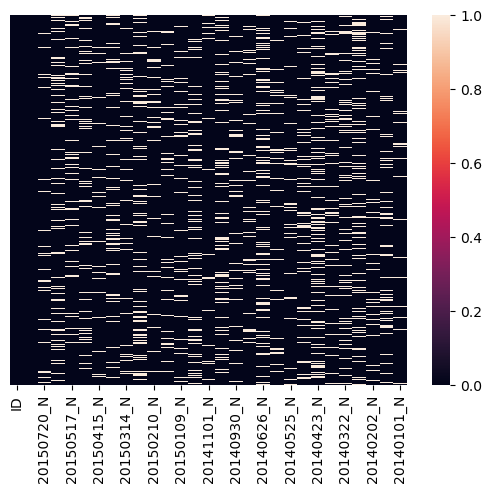

In [9]:
sns.heatmap(df.isnull(),yticklabels=False)

In [11]:
for col in df.columns:
    if col in ['ID', 'class']:
        continue
    means = df.groupby('class')[col].mean()
    for cls in df['class'].unique():
        mean_val = means[cls]
        mask = (df['class'] == cls) & (df[col].isna())
        df.loc[mask, col] = mean_val

In [13]:
df.isnull().sum()

ID            0
class         0
20150720_N    0
20150602_N    0
20150517_N    0
20150501_N    0
20150415_N    0
20150330_N    0
20150314_N    0
20150226_N    0
20150210_N    0
20150125_N    0
20150109_N    0
20141117_N    0
20141101_N    0
20141016_N    0
20140930_N    0
20140813_N    0
20140626_N    0
20140610_N    0
20140525_N    0
20140509_N    0
20140423_N    0
20140407_N    0
20140322_N    0
20140218_N    0
20140202_N    0
20140117_N    0
20140101_N    0
dtype: int64

In [15]:
date_cols = [col for col in df.columns if col not in ['ID','class']]

In [17]:
df1 = df[date_cols] / 1000
df1['ID'] = df['ID']
df1['class'] = df['class']

In [19]:
import pandas as pd
import numpy as np

# Load your dataset (already done)
# df = pd.read_csv("your_file.csv")

# 1. Identify NDVI columns
# Only include columns where the name strictly matches the pattern of a date ending in "_N"
import re

ndvi_cols = [col for col in df1.columns if re.match(r'^\d{8}_N$', col)]


ndvi_long = df1.melt(id_vars=['ID', 'class'],
                    value_vars=ndvi_cols,
                    var_name='date',
                    value_name='NDVI')

# Convert to datetime
ndvi_long['date'] = pd.to_datetime(ndvi_long['date'].str.replace('_N', ''), format='%Y%m%d')

# 4. Sort for time-series filtering
ndvi_long.sort_values(by=['ID', 'date'], inplace=True)

In [21]:
ndvi_long['NDVI_smooth'] = ndvi_long.groupby('ID')['NDVI'].transform(
    lambda x: x.ewm(span=3, adjust=False).mean()
)

In [22]:
# 6. Feature generation for each ID
features = ndvi_long.groupby('ID').agg(
    NDVI_mean=('NDVI_smooth', 'mean'),
    NDVI_std=('NDVI_smooth', 'std'),
    NDVI_max=('NDVI_smooth', 'max'),
    NDVI_min=('NDVI_smooth', 'min'),
    NDVI_range=('NDVI_smooth', lambda x: x.max() - x.min()),
    NDVI_trend=('NDVI_smooth', lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x.dropna()) > 1 else 0)
).reset_index()


In [25]:
# 7. Merge with target label
final_df = df1[['ID', 'class']].merge(features, on='ID')

In [32]:
final_df = pd.concat([df1, final_df], axis=1)

In [34]:
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

In [36]:
final_df.head()

,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,20150210_N,20150125_N,...,20140117_N,20140101_N,ID,class,NDVI_mean,NDVI_std,NDVI_max,NDVI_min,NDVI_range,NDVI_trend
0,0.637595,0.658668,-1.882030,-1.92436,0.997904,-1.739990,0.630087,0.527135,-1.32564,-0.944084,...,-1.180190,0.433906,1,water,-0.072153,0.656496,0.747840,-1.391268,2.139108,-0.014818
1,0.634240,0.593705,-1.625790,-1.67232,0.914198,-0.692386,0.707626,-1.670590,-1.40864,-0.989285,...,-1.360560,0.524075,2,water,-0.155613,0.591687,0.712845,-1.334121,2.046966,-0.013841
2,0.058017,-1.599160,1.101122,-1.05263,1.037901,-1.564630,1.131306,0.729790,-3.16214,1.082291,...,0.973156,-1.343550,4,water,-0.027634,0.615491,1.089082,-1.343550,2.432632,0.009783
3,0.072518,1.628972,0.380436,-1.25693,0.515805,-1.413180,-0.802942,0.683254,-2.82940,-1.267540,...,0.973156,-0.826727,5,water,-0.161897,0.600024,0.720662,-1.623639,2.344302,0.002934
4,1.136440,1.628972,1.101122,1.64783,1.935800,0.931041,2.158980,0.527135,1.24287,-2.646050,...,-0.568050,-1.357140,8,water,0.648926,0.909188,1.862293,-1.357140,3.219433,0.060347


In [38]:
final_df.isnull().sum()

20150720_N    0
20150602_N    0
20150517_N    0
20150501_N    0
20150415_N    0
20150330_N    0
20150314_N    0
20150226_N    0
20150210_N    0
20150125_N    0
20150109_N    0
20141117_N    0
20141101_N    0
20141016_N    0
20140930_N    0
20140813_N    0
20140626_N    0
20140610_N    0
20140525_N    0
20140509_N    0
20140423_N    0
20140407_N    0
20140322_N    0
20140218_N    0
20140202_N    0
20140117_N    0
20140101_N    0
ID            0
class         0
NDVI_mean     0
NDVI_std      0
NDVI_max      0
NDVI_min      0
NDVI_range    0
NDVI_trend    0
dtype: int64

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [42]:
feature_cols = [col for col in final_df.columns if col not in ['ID', 'class']] 
                                                                                      
X = final_df[feature_cols]                        
y = final_df['class']

In [44]:
scaler = StandardScaler()                
X_scaled = scaler.fit_transform(X)

In [46]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_scaled,y)

LogisticRegression(max_iter=1000, random_state=42)

In [48]:
test = pd.read_csv('hacktest.csv')

In [50]:
test1 = test.drop(['Unnamed: 0','ID'],axis=1)

In [52]:
test1 = test[date_cols] / 1000
test1['ID'] = test['ID']

In [54]:
ndvi_cols = [col for col in test1.columns if re.match(r'^\d{8}_N$', col)]


ndvi_long = test1.melt(id_vars=['ID'],
                    value_vars=ndvi_cols,
                    var_name='date',
                    value_name='NDVI')

# Convert to datetime
ndvi_long['date'] = pd.to_datetime(ndvi_long['date'].str.replace('_N', ''), format='%Y%m%d')

# 4. Sort for time-series filtering
ndvi_long.sort_values(by=['ID', 'date'], inplace=True)

In [56]:
ndvi_long['NDVI_smooth'] = ndvi_long.groupby('ID')['NDVI'].transform(
    lambda x: x.ewm(span=3, adjust=False).mean()
)

In [58]:
# 6. Feature generation for each ID
features = ndvi_long.groupby('ID').agg(
    NDVI_mean=('NDVI_smooth', 'mean'),
    NDVI_std=('NDVI_smooth', 'std'),
    NDVI_max=('NDVI_smooth', 'max'),
    NDVI_min=('NDVI_smooth', 'min'),
    NDVI_range=('NDVI_smooth', lambda x: x.max() - x.min()),
    NDVI_trend=('NDVI_smooth', lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x.dropna()) > 1 else 0)

).reset_index()

In [60]:
# 7. Merge with target label
test_df = test1[['ID']].merge(features, on='ID')

In [62]:
test_df = pd.concat([test1, test_df], axis=1)

In [64]:
test_df = test_df.loc[:, ~test_df.columns.duplicated()]

In [66]:
test_df.head()

,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,20150210_N,20150125_N,...,20140202_N,20140117_N,20140101_N,ID,NDVI_mean,NDVI_std,NDVI_max,NDVI_min,NDVI_range,NDVI_trend
0,7.46642,0.413162,5.76100,5.62545,0.489403,3.92384,3.097110,6.76642,2.82913,6.742570,...,4.73675,0.601843,6.639760,1,3.402423,1.268674,6.639760,1.432622,5.207138,0.018632
1,7.23526,6.037350,1.02756,6.08514,1.618050,6.66854,2.513990,1.05169,7.26822,6.908180,...,6.94268,1.070440,0.842101,2,3.565641,1.383217,6.016989,0.842101,5.174888,0.071161
2,7.42508,6.969980,1.17794,7.40893,0.861061,7.64443,0.814458,1.50429,7.00263,6.086560,...,6.92893,1.036560,0.831441,3,3.589844,1.544612,6.246031,0.831441,5.414590,0.073131
3,7.11912,1.731620,6.31193,6.44161,0.465979,7.12842,1.649120,6.93522,2.17680,0.690408,...,6.73472,0.824584,6.883610,4,3.298877,1.529952,6.883610,1.065326,5.818284,0.003329
4,7.51955,8.130260,1.48254,7.87953,1.001210,7.93760,4.122530,1.09451,7.95144,8.001350,...,7.93768,1.857800,1.336920,5,4.270412,1.620546,7.007141,1.336920,5.670221,0.081275


In [68]:
test_df = test_df.drop(['ID'],axis=1)

In [72]:
test_scaled = scaler.transform(test_df)
y_pred = model.predict(test_scaled)

In [74]:
submission = pd.DataFrame({'ID': test.ID, 'y_pred': y_pred})

In [76]:
submission.y_pred.groupby(submission['y_pred']).value_counts()

y_pred      y_pred    
farm        farm           483
forest      forest        1677
grass       grass          163
impervious  impervious     393
orchard     orchard         19
water       water          110
Name: count, dtype: int64

In [78]:
submission.to_csv('submission7.csv',index=False)